## Compute gradients derived from ipsilateral thalamo-cortical FC

* Using FC only between thalamus and cortex within each hemisphere (excluding FC within cortex/thalamus) 
* Gradients in right hemisphere are aligned to gradients from left hemisphere
* For now, only computing thalamo-cortical gradients in thalamic space >> we might look into cortical space later.

1. Template gradient (all subjects)
2. Individual gradients
3. Group-specific gradients

Using **normalized angle kernel** because of asymmetric FC

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting

from brainspace.mesh.mesh_io import read_surface
from brainspace.gradient import GradientMaps
from brainspace.gradient.kernels import compute_affinity

/Users/valkebets/opt/miniconda3/envs/p37/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# Specify files and directories

pth_project = '/Users/valkebets/Documents/Work/project-data/project__sensory_gradients/analyses_clean'
pth_out = root_pth + '/results/gradients_ctx_thal_ipsiLR_sym-thal_aligned_abide1_N211/files')
pth_tools = 'https://raw.githubusercontent.com/valkebets/thalamocortical_gradients/master/data'
pth_demog = pth_tools + '/abide_func_fn_abideI.csv' # tabular data for ABIDE-I participants

# Load FC 

data = np.load(root_pth + 'ipsilateral_FC_symmetric-thal_Schaefer400_abide1_N210.npz')

fc_l = data['fczs_l'] # left thalamo-cortical FC (after Fisher-z transform)
fc_r = data['fczs_r'] # right thalamo-cortical FC (after Fisher-z transform)
n_subj = len(fc_l)
                       
print('Dimensions of left FC matrices:', fc_l.shape)
print('Dimensions of right FC matrices:', fc_r.shape)
print('N subjects = ', n_subj) 

Dimensions of left FC matrices from all subjects = (211, 524, 524)
Dimensions of right FC matrices from all subjects = (211, 524, 524)
N subjects =  211


In [3]:
# Use only FC between cortex and thalamus, not within
# Order of rows in connectivity matrices is: cortex, left thalamus, right thalamus

fc_l = fc_l[:, :200, 200:]
fc_r = fc_r[:, :200, 200:]

print('Dimensions of left/right FC matrices:') # should be 211 x 200 x 324 (or 211 x 524 x 524)
print(fc_l.shape)
print(fc_r.shape)

Dimensions of left cortico-thalamic FC matrices from all subjects = (211, 200, 324)
Dimensions of right cortico-thalamic FC matrices from all subjects = (211, 200, 324)


In [5]:
# Compute mean FC across all subjects

mean_fc_l = fc_l.mean(0)
mean_fc_r = fc_r.mean(0)

# Convert to float object
#mean_fc_l = np.array(mean_fc_l, dtype='f')
#mean_fc_r = np.array(mean_fc_r, dtype='f')

print('Dimensions of mean left/right FC matrix :') # should be 200 x 324 (or 524 x 524)
print(mean_fc_l.shape)
print(mean_fc_r.shape)

After Fisher-z transformation
Dimensions of mean left/right FC matrix :
(200, 324)
(200, 324)
Dimensions of individual left/right FC matrices :
(211, 200, 324)
(211, 200, 324)


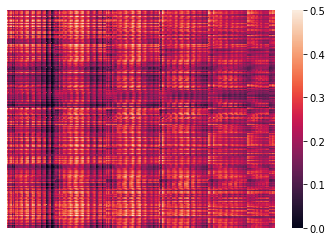

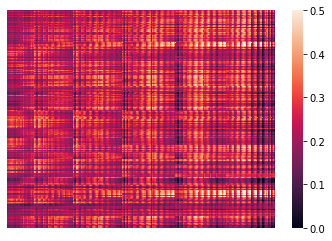

In [7]:
# Plot mean FC

heat_map = sns.heatmap(mean_fc_l, vmin=0, vmax=0.5)
#corr_plot = plotting.plot_matrix(mean_fc_l, figure=(5,5), vmax=0.8, vmin=-0.8) 
plt.xticks([])
plt.yticks([])
plt.xlabel('Left thalamus')
plt.ylabel('Left cortex')
#plt.savefig(pth_out + '/figs/mean_fc_l.png')
plt.show()

heat_map = sns.heatmap(mean_fc_r, vmin=0, vmax=0.5)
#corr_plot = plotting.plot_matrix(mean_fc_r, figure=(5,5), vmax=0.8, vmin=-0.8) 
plt.xticks([])
plt.yticks([])
plt.xlabel('Left thalamus')
plt.ylabel('Left cortex')
#plt.savefig(pth_out + '/figs/mean_fc_r.png')
plt.show()

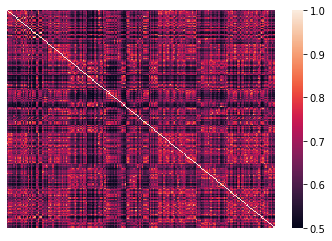

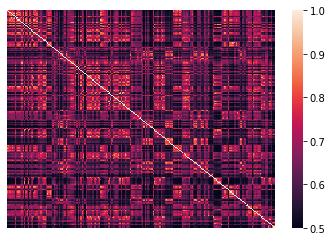

In [8]:
# Plot affinity matrix
# Left
affinity_l = compute_affinity(x=mean_fc_l, kernel='normalized_angle', sparsity=0.9, 
                                   pre_sparsify=True, non_negative=True, gamma=None)

heat_map = sns.heatmap(affinity_lh)#, vmin=0.5, vmax=0.5)
plt.xticks([])
plt.yticks([])
plt.xlabel('Left thalamus')
plt.ylabel('Left cortex')
#plt.savefig(pth_out + '/figs/affinity_norm-angle_mean_fc_l.png')
plt.show()


# Right
affinity_r = compute_affinity(x=mean_fc_r, kernel='normalized_angle', sparsity=0.9, 
                                   pre_sparsify=True, non_negative=True, gamma=None)

heat_map2 = sns.heatmap(affinity_rh)#, vmin=-0.5, vmax=0.5)
plt.xticks([])
plt.yticks([])
plt.xlabel('Left thalamus')
plt.ylabel('Left cortex')
#plt.savefig(pth_out + '/figs/affinity_norm-angle_mean_fc_r.png')
plt.show()

In [10]:
### 1. Template gradient (all subjects)


# Left thalamus
g_templ_l = GradientMaps(kernel='normalized_angle', n_components=10, random_state=0) 
g_templ_l.fit(mean_fc_l.T, sparsity=0.9) 
print('Dimensions of left thalamo-cortical gradient :', g_templ_l.gradients_.shape)

# Right thalamus - aligned with left
g_templ_r = GradientMaps(kernel='normalized_angle', n_components=10, random_state=0, alignment='procrustes')
g_templ_r.fit(mean_fc_r.T, reference=g_templ_l.gradients_, sparsity=0.9)
print('Dimensions of right thalamo-cortical gradient :', g_templ_r.gradients_.shape)

# Select scores of first gradient & concatenate left + right
g1_templ_l = np.array(g_templ_l.gradients_[:,0], dtype='f')
g1_templ_r = np.array(g_templ_r.aligned_[:,0], dtype='f')
g1_templ_lr = np.concatenate([g1_templ_l, g1_templ_r], axis=0)

# Same for G2
g2_templ_l = np.array(g_templ_l.gradients_[:,1], dtype='f')
g2_templ_r = np.array(g_templ_r.aligned_[:,1], dtype='f')
g2_templ_lr = np.concatenate([g2_templ_l, g2_templ_r], axis=0)

# Check dimensions of concatenated gradients
print('Dimensions of concatenated left+right thalamo-cortical gradient 1:', g1_templ_lr.shape)
print('Dimensions of concatenated left+right thalamo-cortical gradient 2:', g2_templ_lr.shape)

Dimensions of left thalamic gradient : (324, 10)
Dimensions of right thalamic gradient : (324, 10)
Dimensions of concatenated left+right thalamic gradient 1: (648,)
Dimensions of concatenated left+right thalamic gradient 2: (648,)


In [12]:
### Save template gradient scores


# Save gradient objects as pickle
filehandler = open(pth_out + '/thal_templ_loadings/templ_gradient_norm-angle_aligned_l.pickle', 'wb')
pickle.dump(gref_thal_lh, filehandler)
filehandler.close()

filehandler = open(pth_out + '/thal_templ_loadings/templ_gradient_norm-angle_aligned_r.pickle', 'wb')
pickle.dump(gref_thal_rh, filehandler)
filehandler.close()

Saving matrices to: /Users/valkebets/Documents/Work/project-data/project__sensory_gradients/analyses_clean/results/gradients_ctx_thal_ipsiLR_sym-thal_aligned_abide1_N211/files/thal_templ_loadings/ref_g1-g2_norm-angle_notaligned_thal_loadings.npz


In [ ]:
# Save G1+G2 scores as npz for further analyses
opth_matrix = os.path.join(pth_project + '/thal_templ_loadings/templ_g1-g2_norm-angle_aligned_loadings.npz')

print(f'Saving matrices to: {opth_matrix}')
np.savez_compressed(opth_matrix, 
                    g1_templ_lr = g1_templ_lr,
                    g2_templ_lr = g2_templ_lr)

In [ ]:
#atlas = np.asanyarray(img.dataobj)
#new_mask = np.zeros_like(atlas)
#new_mask = nib.Nifti1Image(common_thal_lhrh, img.affine, header=img.header)
#nib.save(new_mask, data_dir + '/thalamus_intersectLR_mask_1.nii')


# Save G1 scores as nifti
atlas_nii = nib.load(pth_project + '/data/thalamus_intersectLR_mask_1.nii')
atlas = np.asanyarray(atlas_nii.dataobj)
m = np.isin(atlas, [10, 49])
g1_ref_thal = np.zeros_like(atlas)
g1_ref_thal[m] = g1_ref_thal_lhrh
g1_ref_thal_nii = nib.Nifti1Image(g1_ref_thal, atlas_nii.affine, header=atlas_nii.header)
nib.save(g1_ref_thal_nii, results_pth + '/thal_templ_loadings/templ_g1_norm-angle_aligned_loadings.nii')

# Save G2 scores as nifti
atlas_nii = nib.load(pth_project + '/data/thalamus_intersectLR_mask_1.nii')
atlas = np.asanyarray(atlas_nii.dataobj)
m = np.isin(atlas, [10, 49])
g2_ref_thal = np.zeros_like(atlas)
g2_ref_thal[m] = g2_ref_thal_lhrh
g2_ref_thal_nii = nib.Nifti1Image(g2_ref_thal, atlas_nii.affine, header=atlas_nii.header)
nib.save(g2_ref_thal_nii, results_pth + '/thal_templ_loadings/templ_g2_norm-angle_aligned_loadings.nii')

In [16]:
### 2. Individual gradients & align to template reference gradient

all_g1_ind_l = [] 
all_g1_ind_r = [] 
all_g2_ind_l = [] 
all_g2_ind_r = [] 

for i in range(n_subj):
    
    # Left thalamus - Aligned to left template gradient
    g_ind_l = GradientMaps(kernel='normalized_angle', n_components=10, random_state=0, alignment='procrustes')
    g_ind_l.fit(fc_l[i,:][:, :].T, reference=g_templ_l.gradients_, sparsity=0.9)
    
    # Right thalamus - Aligned to right template gradient
    g_ind_r = GradientMaps(kernel='normalized_angle', n_components=10, random_state=0, alignment='procrustes')
    g_ind_r.fit(fc_r[i,:][:, :].T, reference=g_templ_r.aligned_, sparsity=0.9)

    # Select scores from first gradient
    all_g1_ind_l.append(g_ind_l.aligned_[:, 0])
    all_g1_ind_r.append(g_ind_r.aligned_[:, 0])

    # Select scores from second gradient
    all_g2_ind_l.append(g_ind_l.aligned_[:, 1])
    all_g2_ind_r.append(g_ind_r.aligned_[:, 1])
    

# Convert to float
all_g1_ind_l = np.array(all_g1_ind_l, dtype='f')
all_g1_ind_r = np.array(all_g1_ind_r, dtype='f')
print('Dimensions of all individual (first) gradients:')
print('Left thalamus:', all_g1_ind_l.shape) 
print('Right thalamus:', all_g1_ind_r.shape) 

all_g2_ind_l = np.array(all_g2_ind_l, dtype='f')
all_g2_ind_r = np.array(all_g2_ind_r, dtype='f')
print('Dimensions of all individual (second) gradients:')
print('Left thalamus:', all_g2_ind_l.shape) 
print('Right thalamus:', all_g2_ind_r.shape) 

# Concatenate the two gradients for plotting
all_g1_ind_lr = np.concatenate([all_g1_ind_l, all_g1_ind_r], axis=1)
print('Dimensions of all bilateral individual (first) gradients in bilateral thalamus:', all_g1_ind_lr.shape)

all_g2_ind_lr = np.concatenate([all_g2_ind_l, all_g2_ind_r], axis=1)
print('Dimensions of all bilateral individual (second) gradients in bilateral thalamus:', all_g2_ind_lr.shape)

Dimensions of all individual (first) gradients:
Left thalamus: (211, 324)
Right thalamus: (211, 324)
Dimensions of all individual (second) gradients:
Left thalamus: (211, 324)
Right thalamus: (211, 324)
Dimensions of all bilateral individual (first) gradients in bilateral thalamus: (211, 648)
Dimensions of all bilateral individual (second) gradients in bilateral thalamus: (211, 648)


In [18]:
# Save individual gradient scores

opth_matrix = pth_project + '/thal_ind_loadings/ind_g1-g2_norm-angle_aligned_loadings.npz'

print(f'Saving matrices to: {opth_matrix}')
np.savez_compressed(opth_matrix, 
                    all_g1_ind_lr = all_g1_ind_lr,
                    all_g2_ind_lr = all_g2_ind_lr)

Saving matrices to: /Users/valkebets/Documents/Work/project-data/project__sensory_gradients/analyses_clean/results/gradients_ctx_thal_ipsiLR_sym-thal_aligned_abide1_N211/files/thal_ind_loadings/ind_g1-g2_norm-angle_notaligned_thal_loadings.npz


In [19]:
### 3. Group-averaged gradients


# Load demographics with subject IDs
df =  pd.read_csv(pth_demog, header=0, index_col=0)

# Keep only selected columns
df = df[['ID','OrgID','Group','Site','Func_MeanFD']]

# Remove subject with high head motiton (FD > 0.3)
df = df.loc[(df['Func_MeanFD'] < 0.3)]

# Move subject 32183 to end
#subj_idx = df.index[df.ID == 32183]
#subj_idx_list = subj_idx.tolist()
#print('Index of subject 32183:', subj_idx_list)

def shift_row_to_bottom(df, index_to_shift):
    idx = [i for i in df.index if i!=index_to_shift]
    return df.loc[idx+[index_to_shift]]

#df = shift_row_to_bottom(df, 172)

# Reset index
df.reset_index(drop=True, inplace=True)

# Get group indices
asd_idx = df.index[df['Group'] == 'ASD'].tolist()
print(len(asd_idx), 'ASD subjects')

td_idx = df.index[df['Group'] == 'CONTROL'].tolist()
print(len(td_idx), 'TD subjects')

df

103 ASD subjects
108 TD subjects


,ID,OrgID,Group,Site,Func_MeanFD
0,32319,50002,ASD,Pitt,0.116828
1,32321,50004,ASD,Pitt,0.127745
2,32581,50006,ASD,Pitt,0.070143
3,32323,50007,ASD,Pitt,0.151246
4,32324,50008,ASD,Pitt,0.169275
...,...,...,...,...,...
206,32253,51153,CONTROL,NYU,0.045803
207,32254,51154,CONTROL,NYU,0.052091
208,32255,51155,CONTROL,NYU,0.043319
209,32256,51156,CONTROL,NYU,0.100715


In [20]:
# Get group-specific gradients

all_g1_ind_lr_asd = all_g1_ind_lr[asd_idx,:]
all_g2_ind_lr_asd = all_g2_ind_lr[asd_idx,:]
print('Dimensions of individual G1 thalamic scores for ASD subjects:', all_g1_ind_lr_asd.shape) 
print('Dimensions of individual G2 thalamic scores for ASD subjects:', all_g2_ind_lr_asd.shape) 


all_g1_ind_lr_td = all_g1_ind_lr[td_idx,:]
all_g2_ind_lr_td = all_g2_ind_lr[td_idx,:]
print('Dimensions of individual G1 thalamic scores for TD subjects:', all_g1_ind_lr_td.shape) 
print('Dimensions of individual G2 thalamic scores for TD subjects:', all_g2_ind_lr_td.shape)

Dimensions of individual G1 thalamic scores for ASD subjects: (103, 648)
Dimensions of individual G2 thalamic scores for ASD subjects: (103, 648)
Dimensions of individual G1 thalamic scores for TD subjects: (108, 648)
Dimensions of individual G2 thalamic scores for TD subjects: (108, 648)


In [21]:
# Average individual gradient scores for each group

mean_g1_ind_lr_asd = all_g1_ind_lr_asd.mean(0)
mean_g1_ind_lr_td = all_g1_ind_lr_td.mean(0)

print('Dimensions of group-averaged gradient:') # should be 648
print('ASD: ', mean_g1_ind_lr_asd.shape)
print('TD: ', mean_g1_ind_lr_td.shape)

# Same for G2
mean_g2_ind_lr_asd = all_g2_ind_lr_asd.mean(0)
mean_g2_ind_lr_td = all_g2_ind_lr_td.mean(0)

Dimensions of group-averaged gradient:
ASD:  (648,)
TD:  (648,)


In [22]:
### Save group-averaged gradient scores as npz for further analyses

opth_matrix = pth_project + '/thal_group_loadings/g1-g2_norm-angle_aligned_loadings_asd_td.npz'

print(f'Saving matrices to: {opth_matrix}')
np.savez_compressed(opth_matrix, 
                    mean_g1_ind_lr_asd = mean_g1_ind_lr_asd,
                    mean_g1_ind_lr_td = mean_g1_ind_lr_td,
                    mean_g2_ind_lr_asd = mean_g2_ind_lr_asd,
                    mean_g2_ind_lr_td = mean_g2_ind_lr_td)

Saving matrices to: /Users/valkebets/Documents/Work/project-data/project__sensory_gradients/analyses_clean/results/gradients_ctx_thal_ipsiLR_sym-thal_aligned_abide1_N211/files/thal_group_loadings/g1-g2_norm-angle_notaligned_thal_loadings_asd_td.npz


In [ ]:
# Save loadings as nifti files for visualization

atlas_nii = nib.load(root_pth + '/data/thalamus_intersectLR_mask_1.nii')
atlas = np.asanyarray(atlas_nii.dataobj)
m = np.isin(atlas, [10, 49])

## G1
# ASD
g1_thal_asd = np.zeros_like(atlas)
g1_thal_asd[m] = mean_g1_ind_lr_asd
g1_thal_asd_nii = nib.Nifti1Image(g1_thal_asd, atlas_nii.affine, header=atlas_nii.header)
nib.save(g1_thal_asd_nii, pth_project + '/thal_group_loadings/g1_norm-angle_aligned_mean_loadings_asd.nii')
         
# TD
g1_thal_td = np.zeros_like(atlas)
g1_thal_td[m] = mean_g1_ind_lr_td
g1_thal_td_nii = nib.Nifti1Image(g1_thal_td, atlas_nii.affine, header=atlas_nii.header)
nib.save(g1_thal_td_nii, pth_project + '/thal_group_loadings/g1_norm-angle_aligned_mean_loadings_td.nii')

## Same for G2
# ASD
g2_thal_asd = np.zeros_like(atlas)
g2_thal_asd[m] = mean_g2_ind_lr_asd
g2_thal_asd_nii = nib.Nifti1Image(g2_thal_asd, atlas_nii.affine, header=atlas_nii.header)
nib.save(g2_thal_asd_nii, pth_project + '/thal_group_loadings/g2_norm-angle_aligned_mean_loadings_asd.nii')

# TD
g2_thal_td = np.zeros_like(atlas)
g2_thal_td[m] = mean_g2_ind_lr_td
g2_thal_td_nii = nib.Nifti1Image(g2_thal_td, atlas_nii.affine, header=atlas_nii.header)
nib.save(g2_thal_td_nii, pth_project + '/thal_group_loadings/g2_norm-angle_aligned_mean_loadings_td.nii')